# Experiments for NIPS 2016
---

* ~~Inspect JA, EE trajectories for Clothing Assistance Tasks~~
* ~~Inspect latent trajectories from BGPLVM Models~~
* ~~Fit DMP to Joint Angle trajectories and Latent Space trajectories~~
* ~~Extract via-points from desired trajectory~~
* ~~Generate plots with raw, dmp, desired trajectories and via-points~~
* ~~Time normalize trajectories for cost function~~
* ~~Design cost function to learn desired trajectory~~
* ~~Obtain DMP parameter vectors for Policy~~
* ~~Implement CEM reinforcement learning for JA case~~
* ~~Apply CEM RL to both JA,EE and corresponding latent space models~~
* ~~Compile results of applying RL~~

## Environment Setup
---

In [1]:
# import the modules
import os
import sys
import GPy
import csv
import time
import pydmps
import random
import matplotlib
import numpy as np
from os import listdir
from plotFuncs import *
import cPickle as pickle
from matplotlib import cm
from viapointExtract import *
from os.path import isfile, join
from matplotlib import pyplot as plt
from pydmps.dmp_discrete import DMPs_discrete
from GPy.plotting.matplot_dep.controllers.imshow_controller import ImshowController
from GPy.inference.latent_function_inference import InferenceMethodList, VarDTC, VarDTC_minibatch

%matplotlib notebook

In [10]:
# load the processed dataset
data = pickle.load(open('Data/Data.p','r'))

# load the ja and ee models
jaModels = pickle.load(open('Results/JAModels.p','r'))
eeModels = pickle.load(open('Results/EEModels.p','r'))

models = {'JA':jaModels,'EE':eeModels}

## Data Inspection
---

<IPython.core.display.Javascript object>


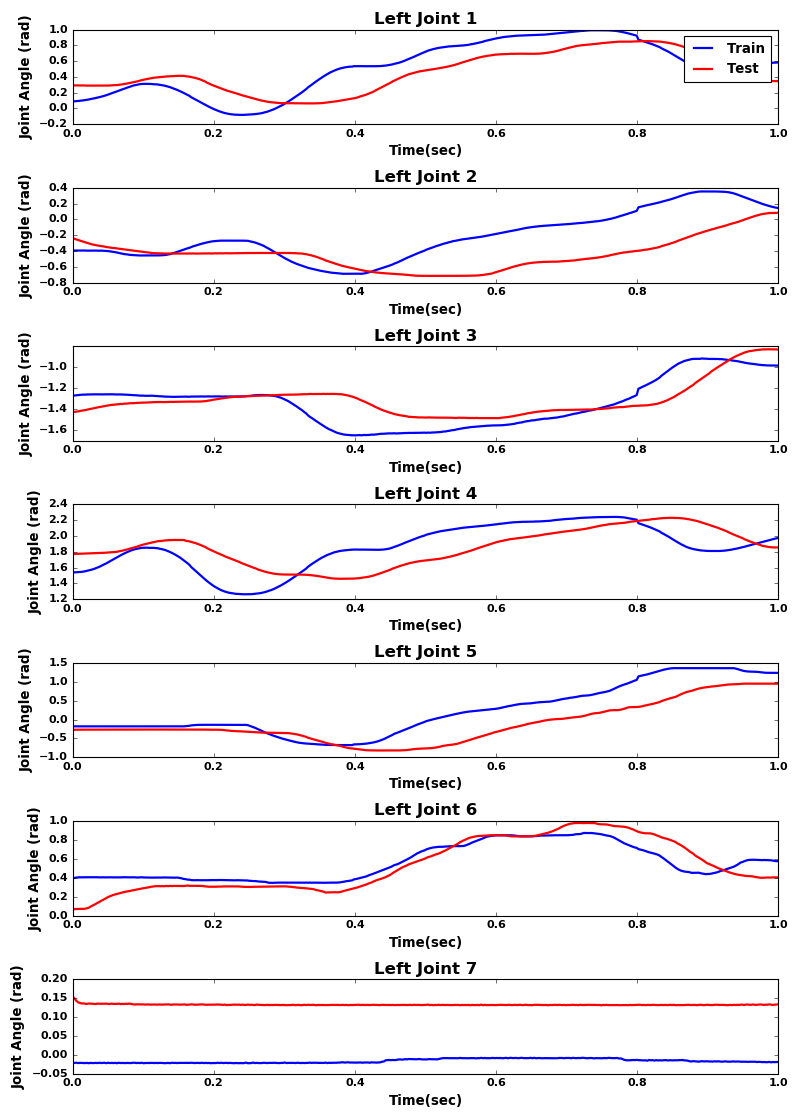

<IPython.core.display.Javascript object>


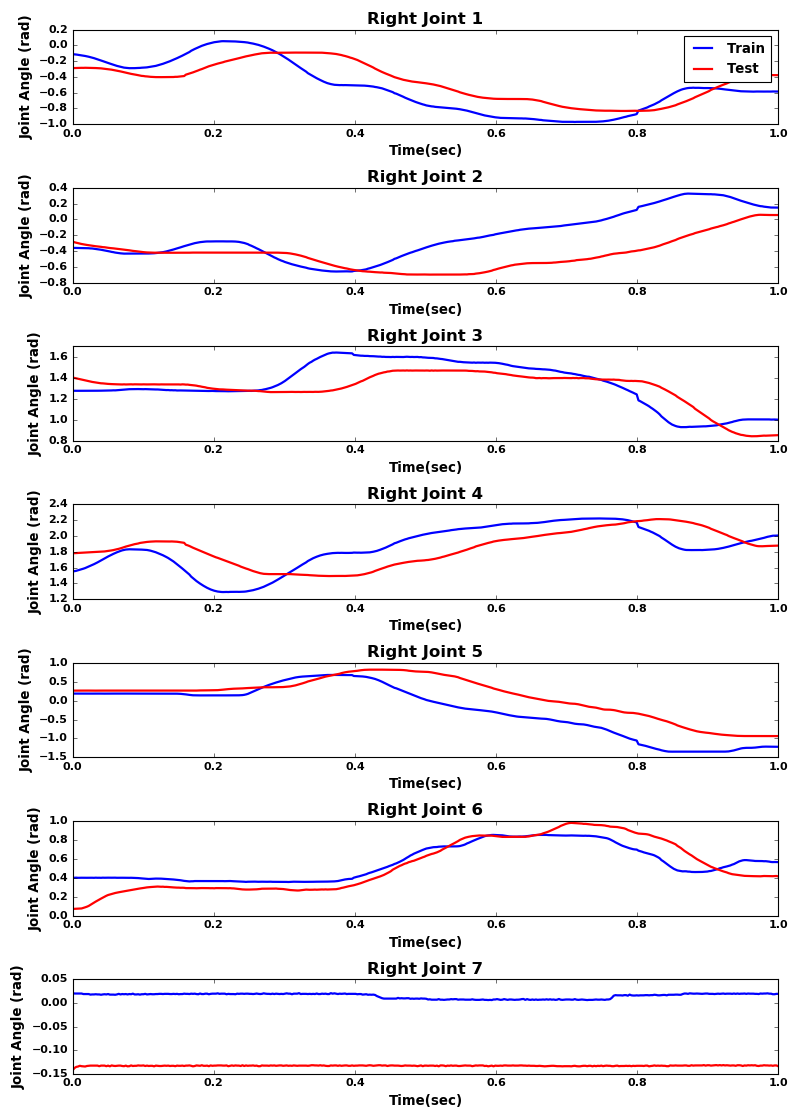

<IPython.core.display.Javascript object>


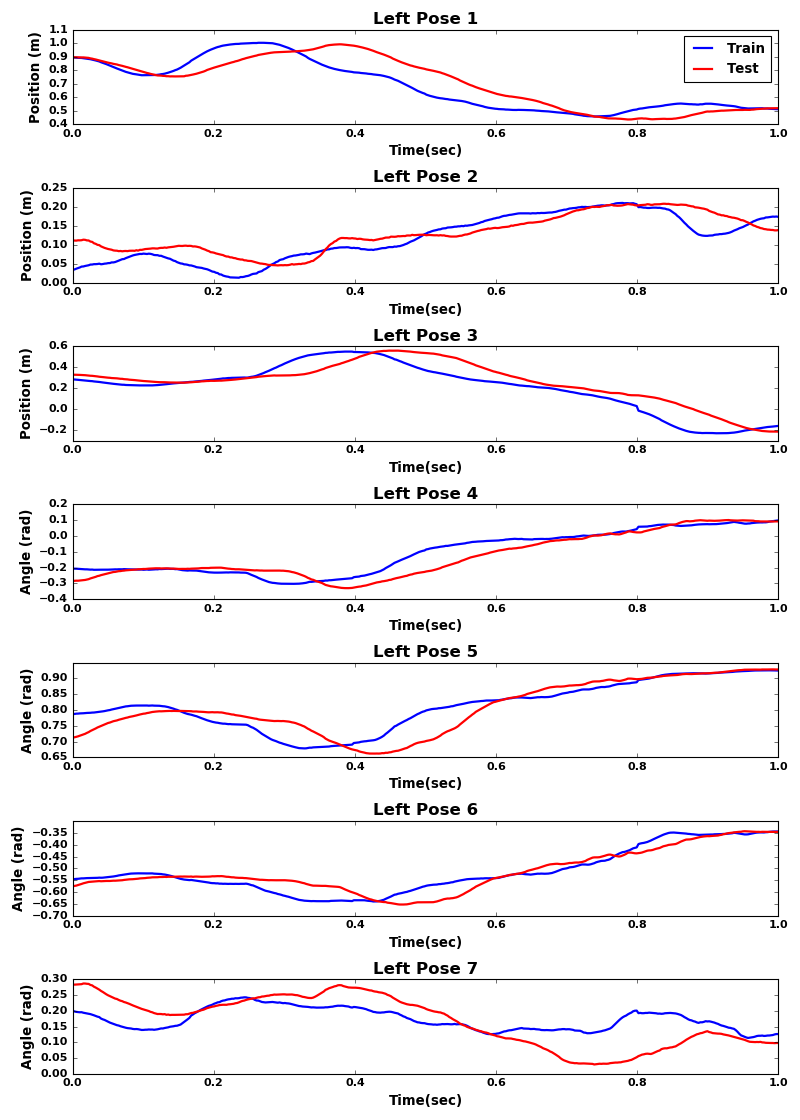

<IPython.core.display.Javascript object>


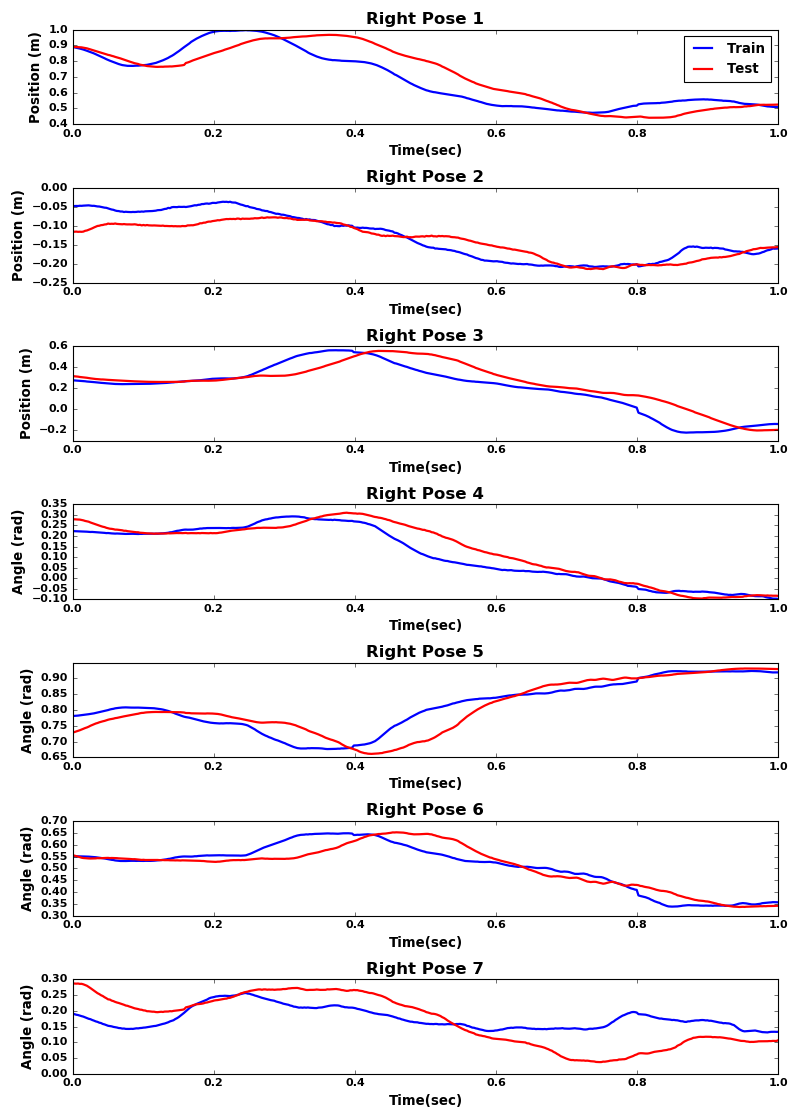

In [3]:
# set the train and test data trials
datasets = {}
keys = ['JA','EE']
for ind, key in enumerate(keys):
    trData = data[key]['65']
    tsData = data[key]['75']
    
    trData[:,0] = np.linspace(0.0, 1.0, endpoint=True, num=trData.shape[0], dtype=np.float)
    tsData[:,0] = np.linspace(0.0, 1.0, endpoint=True, num=tsData.shape[0], dtype=np.float)
    
    datasets[key] = {'Train':trData, 'Test':tsData}
    plotTraj(datasets[key], plotType=ind, jointIndex=np.asarray([0,1,2,3,4,5,6]))

## Latent Data Inspection
---

<IPython.core.display.Javascript object>


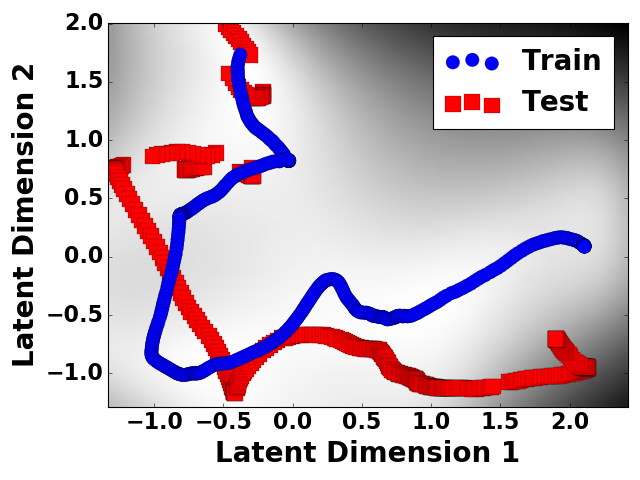

................................................................................................................................................................................................................................................................................................................................................................................................................
................................................................................................................................................................................................................................................................................................................................................................................................................
......................................................................................................................................................................................................

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


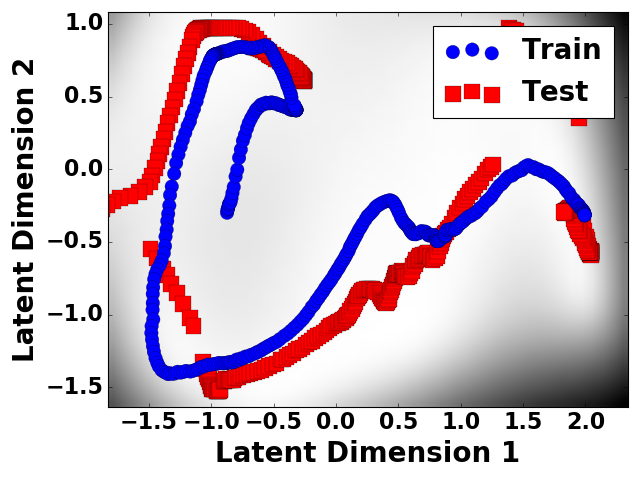

................................................................................................................................................................................................................................................................................................................................................................................................................
................................................................................................................................................................................................................................................................................................................................................................................................................
......................................................................................................................................................................................................

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
latentsets = {}

for key in keys:
    latentsets[key] = {'BGPLVM':{}, 'GPLVM':{}, 'PCA':{}}
    
    (trLatent, tsLatent) = plotLatent(models[key]['BGPLVM'], datasets[key]['Train'][:,1:], datasets[key]['Test'][:,1:])
    trLatent = np.concatenate((np.transpose(np.atleast_2d(datasets[key]['Train'][:,0])),trLatent),axis=1)
    tsLatent = np.concatenate((np.transpose(np.atleast_2d(datasets[key]['Test'][:,0])),tsLatent),axis=1)
    latentsets[key]['BGPLVM'] = {'Train':trLatent,'Test':tsLatent}
    
    (trLatent, tsLatent) = gplvmLatent(models[key]['GPLVM'], datasets[key]['Train'][:,1:], datasets[key]['Test'][:,1:])
    trLatent = np.concatenate((np.transpose(np.atleast_2d(datasets[key]['Train'][:,0])),trLatent),axis=1)
    tsLatent = np.concatenate((np.transpose(np.atleast_2d(datasets[key]['Test'][:,0])),tsLatent),axis=1)
    latentsets[key]['GPLVM'] = {'Train':trLatent,'Test':tsLatent}
    
    (trLatent, tsLatent) = pcaLatent(models[key]['PCA']['model'], datasets[key]['Train'][:,1:], datasets[key]['Test'][:,1:])
    trLatent = np.concatenate((np.transpose(np.atleast_2d(datasets[key]['Train'][:,0])),trLatent),axis=1)
    tsLatent = np.concatenate((np.transpose(np.atleast_2d(datasets[key]['Test'][:,0])),tsLatent),axis=1)
    latentsets[key]['PCA'] = {'Train':trLatent,'Test':tsLatent}
    
    # plot latent trajectories
    plotTraj2(latentsets[key]['BGPLVM'])
    plotTraj2(latentsets[key]['GPLVM'])
    plotTraj2(latentsets[key]['PCA'])

In [12]:
Data = {'input':datasets, 
        'bgplvm':{'JA':latentsets['JA']['BGPLVM'], 'EE':latentsets['EE']['BGPLVM']}, 
        'gplvm':{'JA':latentsets['JA']['GPLVM'], 'EE':latentsets['EE']['GPLVM']}, 
        'pca':{'JA':latentsets['JA']['PCA'], 'EE':latentsets['EE']['PCA']}}
pickle.dump(Data,open('Data/RLData.p','wb'))

## DMP on Trajectories
---

In [26]:
Data = pickle.load(open('Data/RLData.p','rb'))

<IPython.core.display.Javascript object>


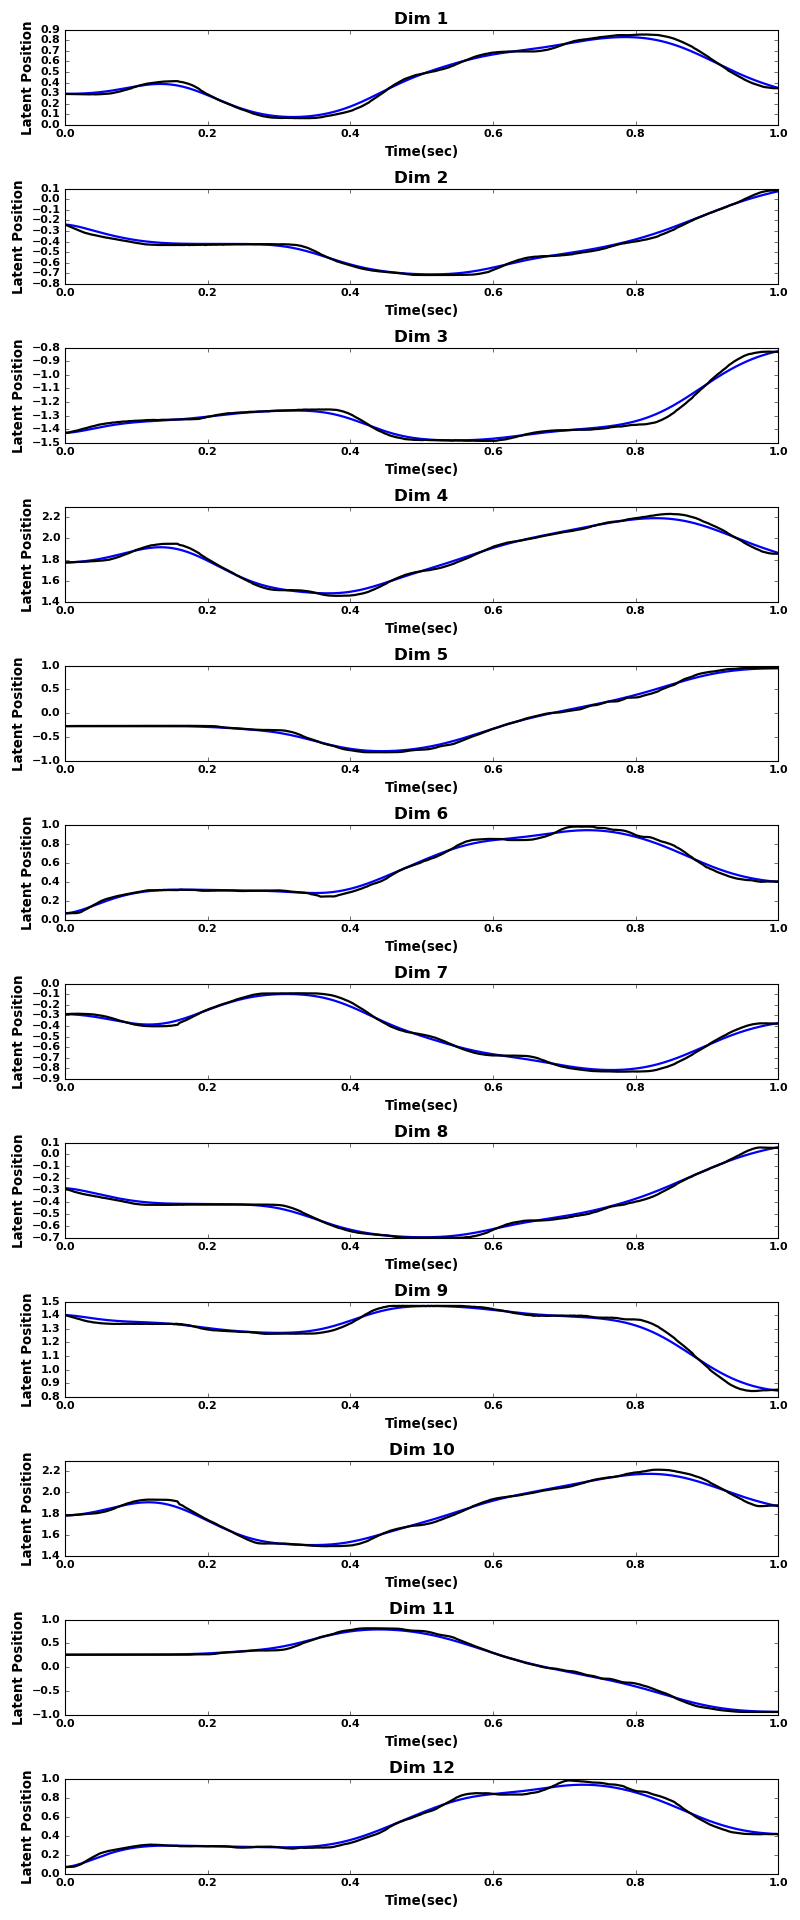

input,JA:Done


<IPython.core.display.Javascript object>


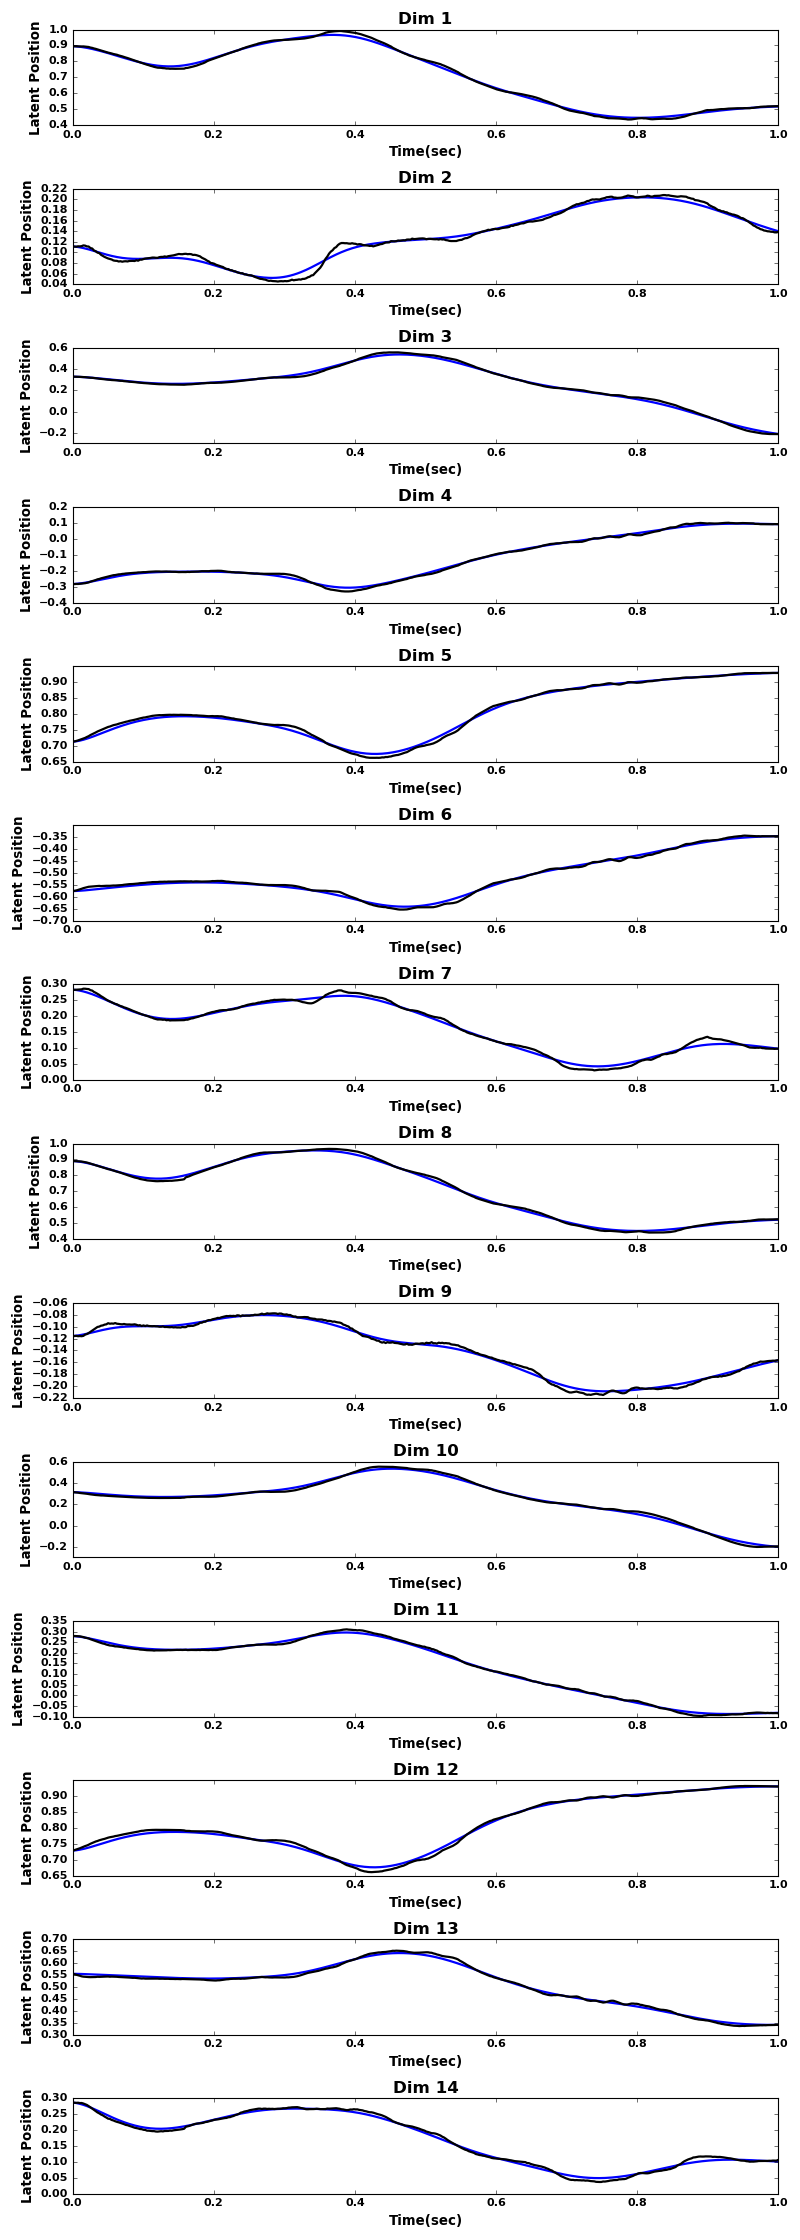

input,EE:Done


<IPython.core.display.Javascript object>


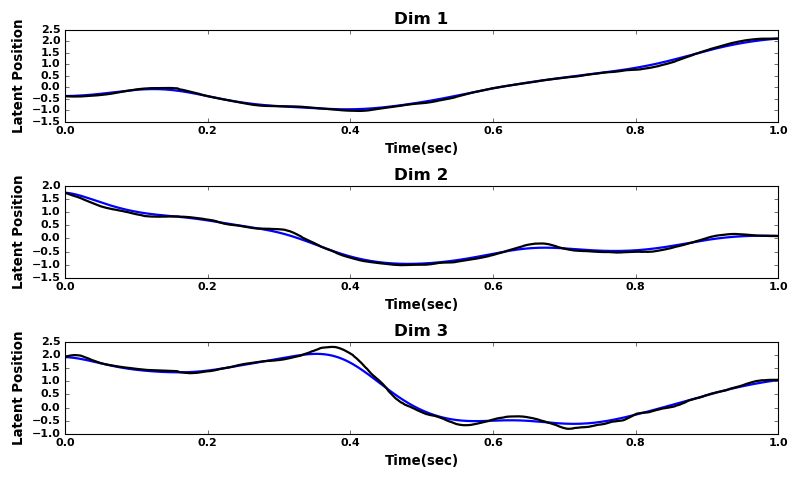

bgplvm,JA:Done


<IPython.core.display.Javascript object>


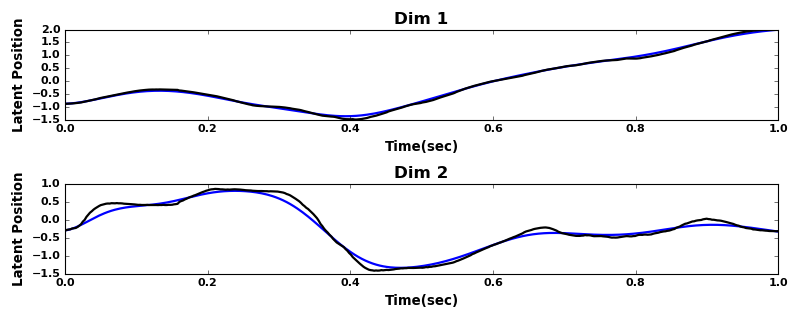

bgplvm,EE:Done


<IPython.core.display.Javascript object>


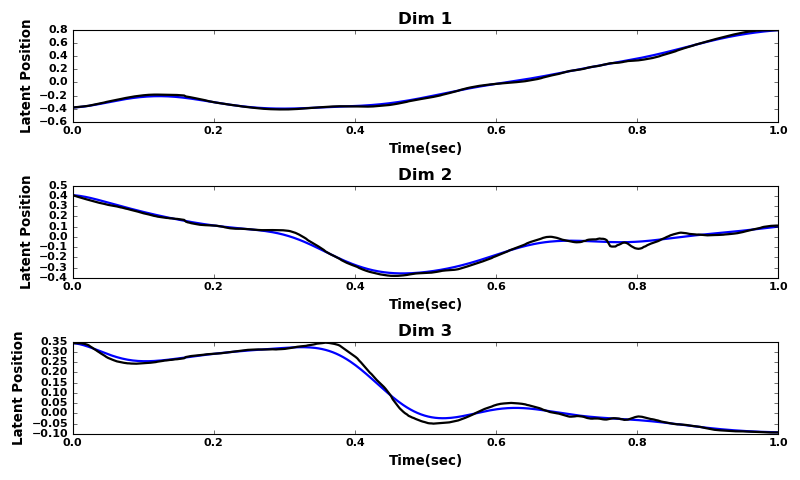

gplvm,JA:Done


<IPython.core.display.Javascript object>


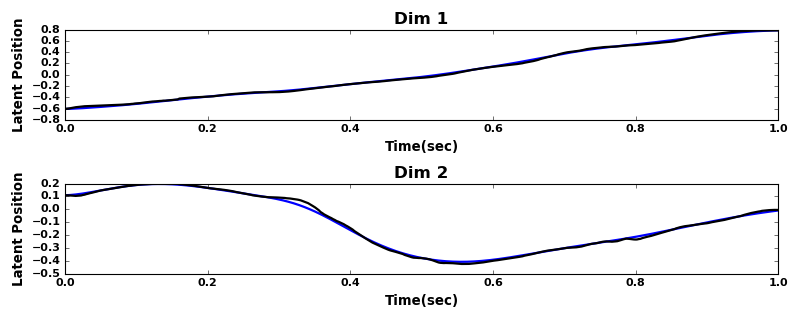

gplvm,EE:Done


<IPython.core.display.Javascript object>


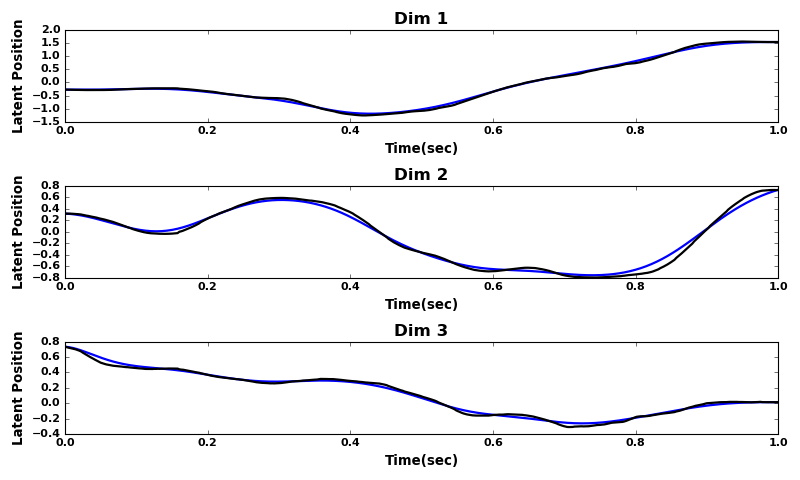

pca,JA:Done


<IPython.core.display.Javascript object>


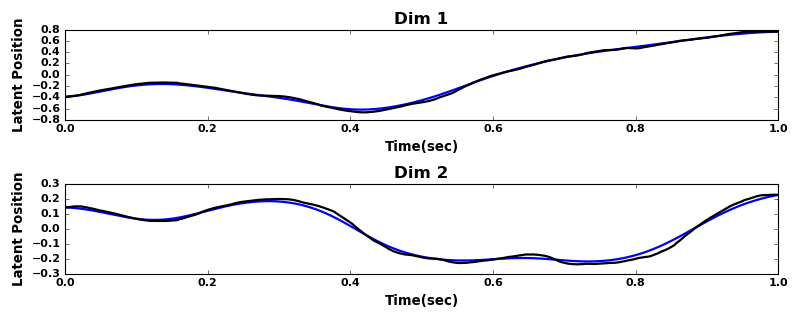

pca,EE:Done


In [27]:
# initialize parameters for training DMPs
nBFS = 100
source = 'Train'
keys = ['JA', 'EE']
modalities = ['input', 'bgplvm', 'gplvm', 'pca']
dims = {'input':{'JA':np.asarray(range(7)+range(8,14)), 'EE':np.arange(15)},
        'bgplvm':{'JA':np.arange(Data['bgplvm']['JA']['Train'].shape[1]),
                  'EE':np.arange(Data['bgplvm']['EE']['Train'].shape[1])},
        'gplvm':{'JA':np.arange(Data['gplvm']['JA']['Train'].shape[1]),
                 'EE':np.arange(Data['gplvm']['EE']['Train'].shape[1])},
        'pca':{'JA':np.arange(Data['pca']['JA']['Train'].shape[1]),
               'EE':np.arange(Data['pca']['EE']['Train'].shape[1])}}

dmps = {}
dmpTrajs = {}
for modality in modalities:
    # setup the dicts with modality
    dmps[modality] = {}
    dmpTrajs[modality] = {}
    
    for key in keys:
        # get the relevant dimensions
        inputDim = dims[modality][key]
        data = Data[modality][key][source][:,inputDim]
        
        # initialize parameters to train DMP
        dt = 1.0/data.shape[0]
        nDims = inputDim.shape[0]-1
        
        # setup and train the DMP
        dmp = DMPs_discrete(dmps=nDims, bfs=nBFS, dt=dt)
        dmp.imitate_path(y_des=np.transpose(data[:,1:]))
        
        # generate a rollout from trained DMP
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(data[:,0])),dmpTraj),axis=1)
        
        # save the results to dicts
        dmps[modality][key] = dmp
        dmpTrajs[modality][key] = dmpTraj
        
        plotTraj2({'Raw':data,'DMP':dmpTraj}, colors={'Raw':'k','DMP':'b'})
        
        print '%s,%s:Done' % (modality,key)
        
pickle.dump(dmpTrajs, open('Results/DMP.p','wb'))

## Viapoints from Trajectories
---

In [28]:
Data = pickle.load(open('Data/RLData.p','rb'))

<IPython.core.display.Javascript object>


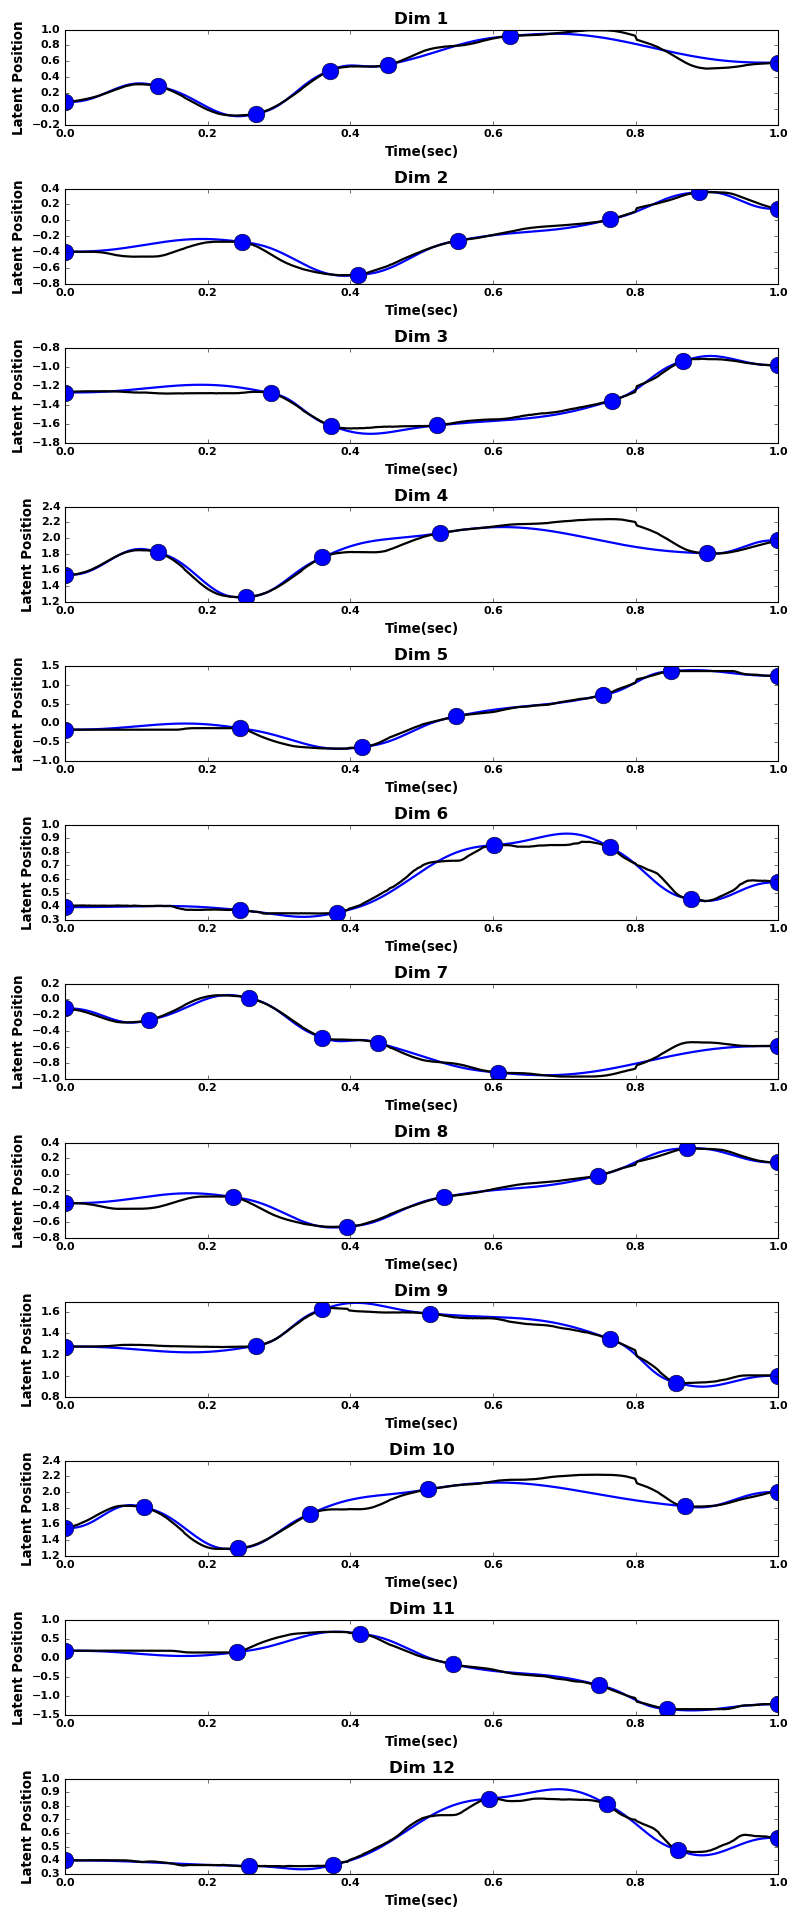

input,JA:Done


<IPython.core.display.Javascript object>


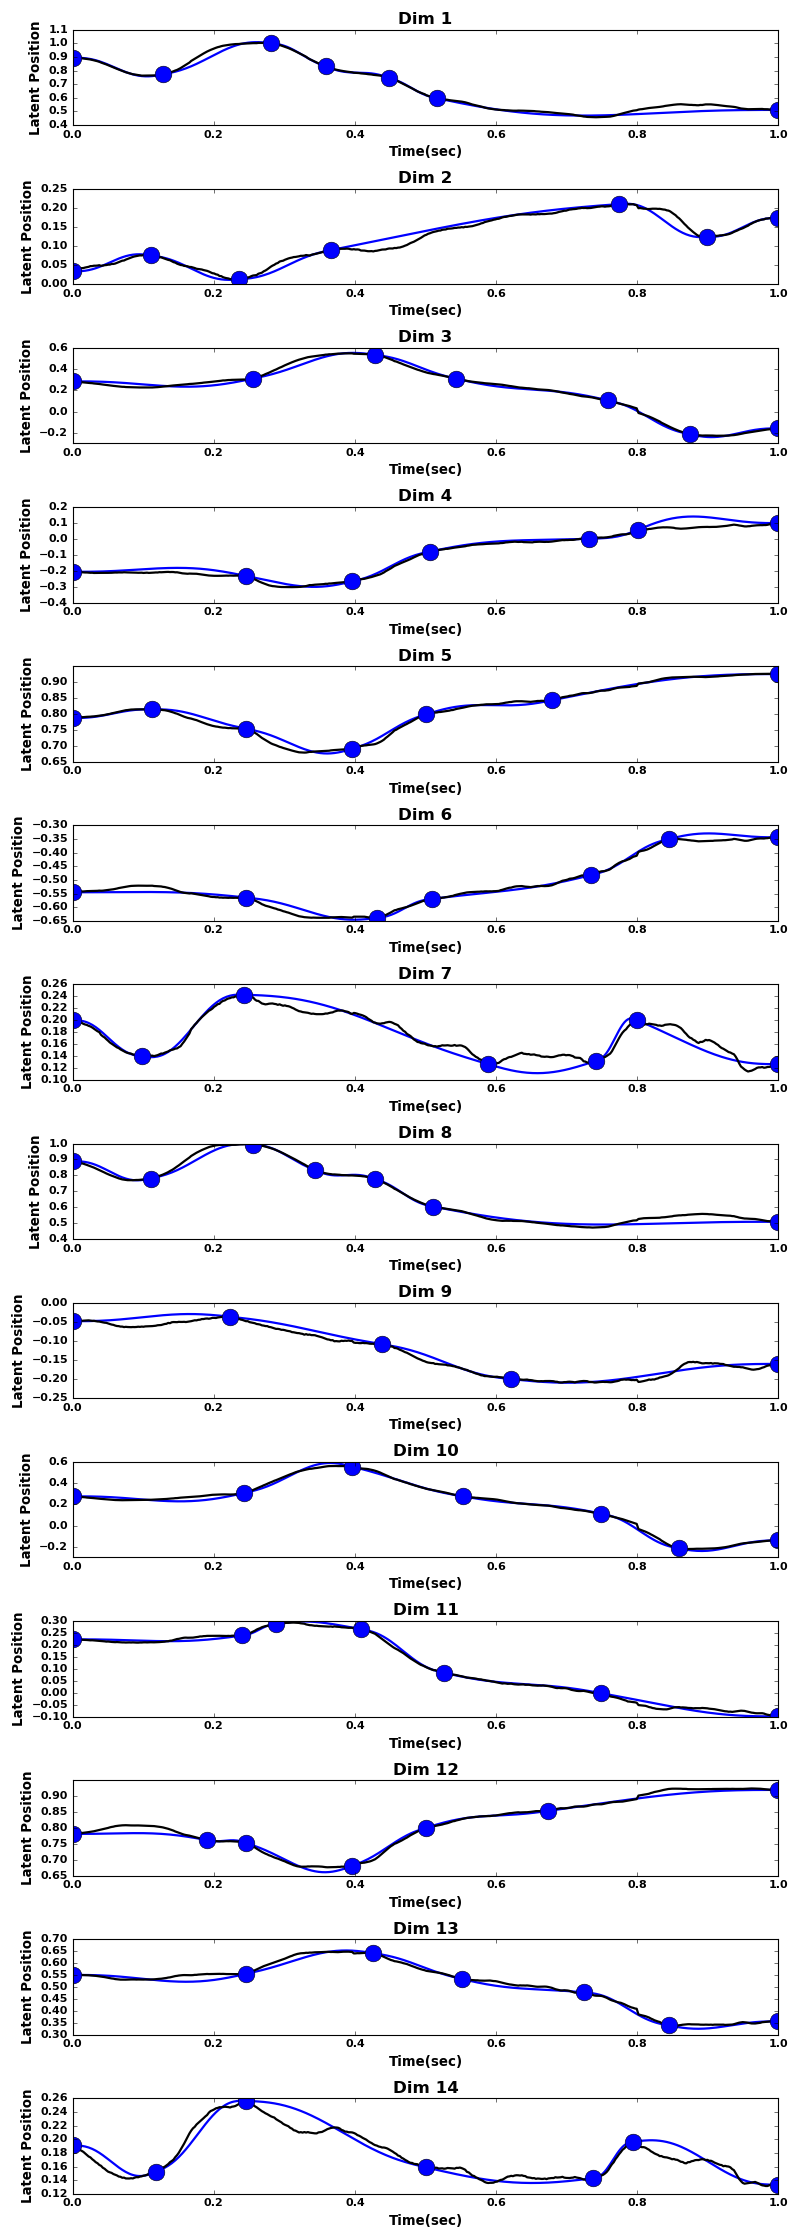

input,EE:Done


In [29]:
# initialize parameters for training DMPs
nVia = 7
source = 'Test'
modality = 'input'
keys = ['JA', 'EE']
dims = {'input':{'JA':np.asarray(range(7)+range(8,14)), 'EE':np.arange(15)}}

# objects and trajectories
viapointObjs = {}
viapointTrajs = {}
viapointParams = {}

for key in keys:
    # get the relevant dimensions
    inputDim = dims[modality][key]
    data = Data[modality][key][source][:,inputDim]
        
    # initialize viapoint extractor instance
    nDims = inputDim.shape[0]-1
    viapoint = ViaPoint(data, nDims=nDims, nViaPoints=nVia, errThresh=0.01)
    (viapointTraj, viapointParam) = viapoint.compute()

    # save the results to dicts
    viapointObjs[key] = viapoint
    viapointTrajs[key] = viapointTraj
    viapointParams[key] = viapointParam
    
    plotTraj2({'Raw':data,'VP':viapointTraj}, points = viapointParam, colors={'Raw':'k','VP':'b'})
    #viapoint.plot(viapointParams)
    print '%s,%s:Done' % (modality,key)
    
VP = {'Trajs':viapointTrajs, 'Params':viapointParams}
pickle.dump(VP, open('Results/VP.p','wb'))    

## Compile DMP, VP results
---

<IPython.core.display.Javascript object>


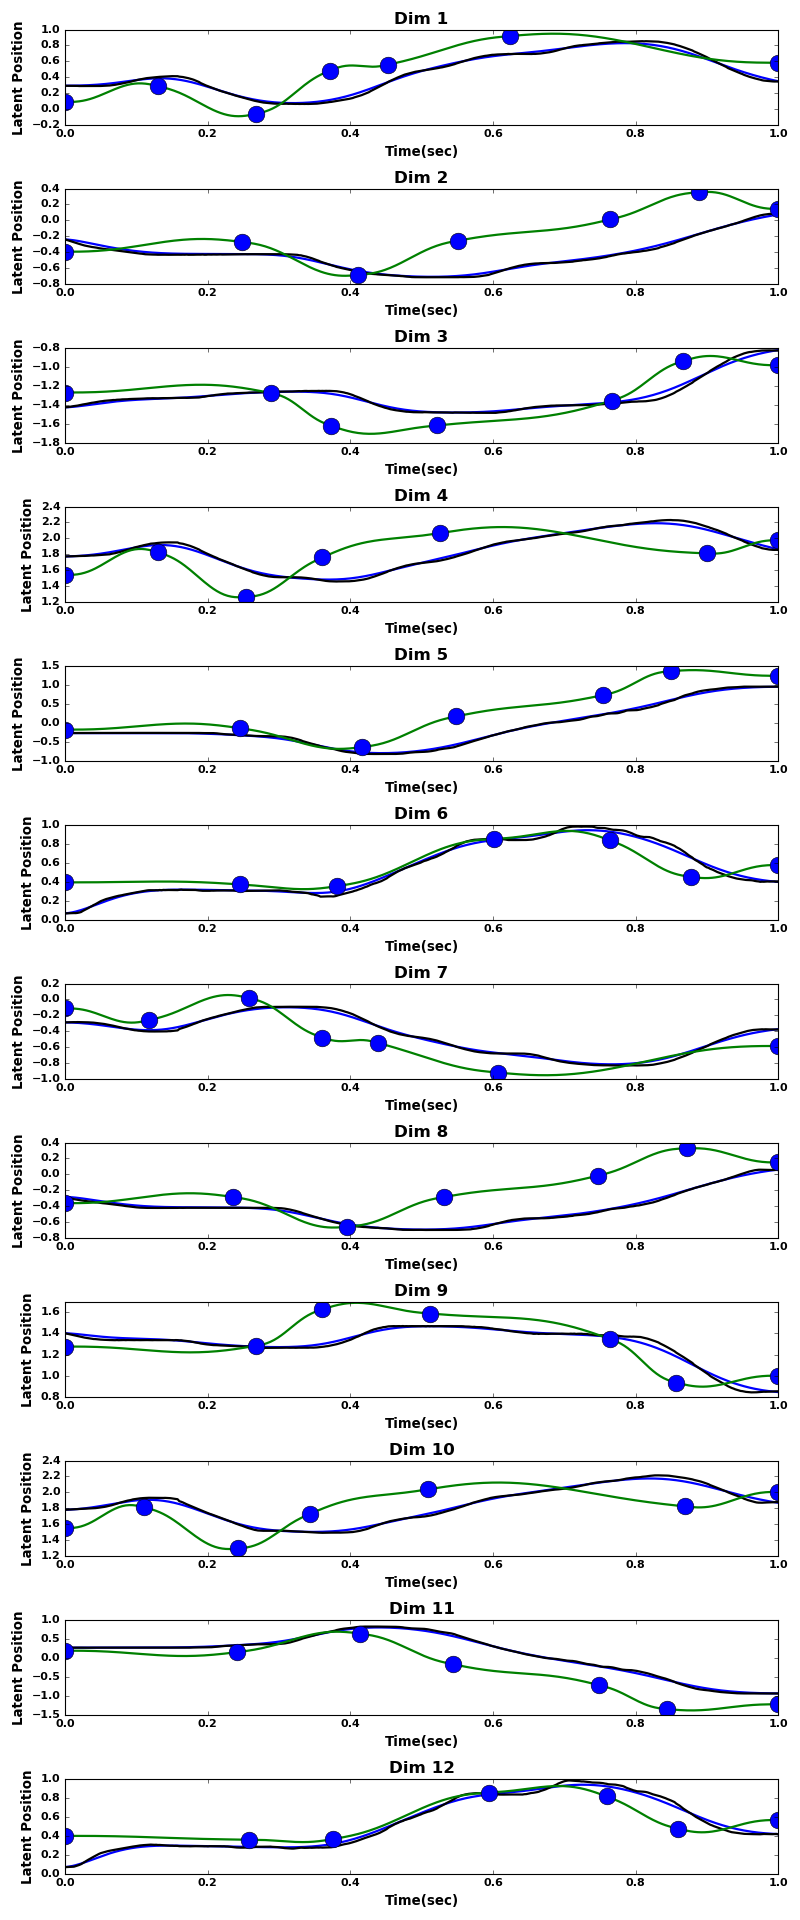

<IPython.core.display.Javascript object>


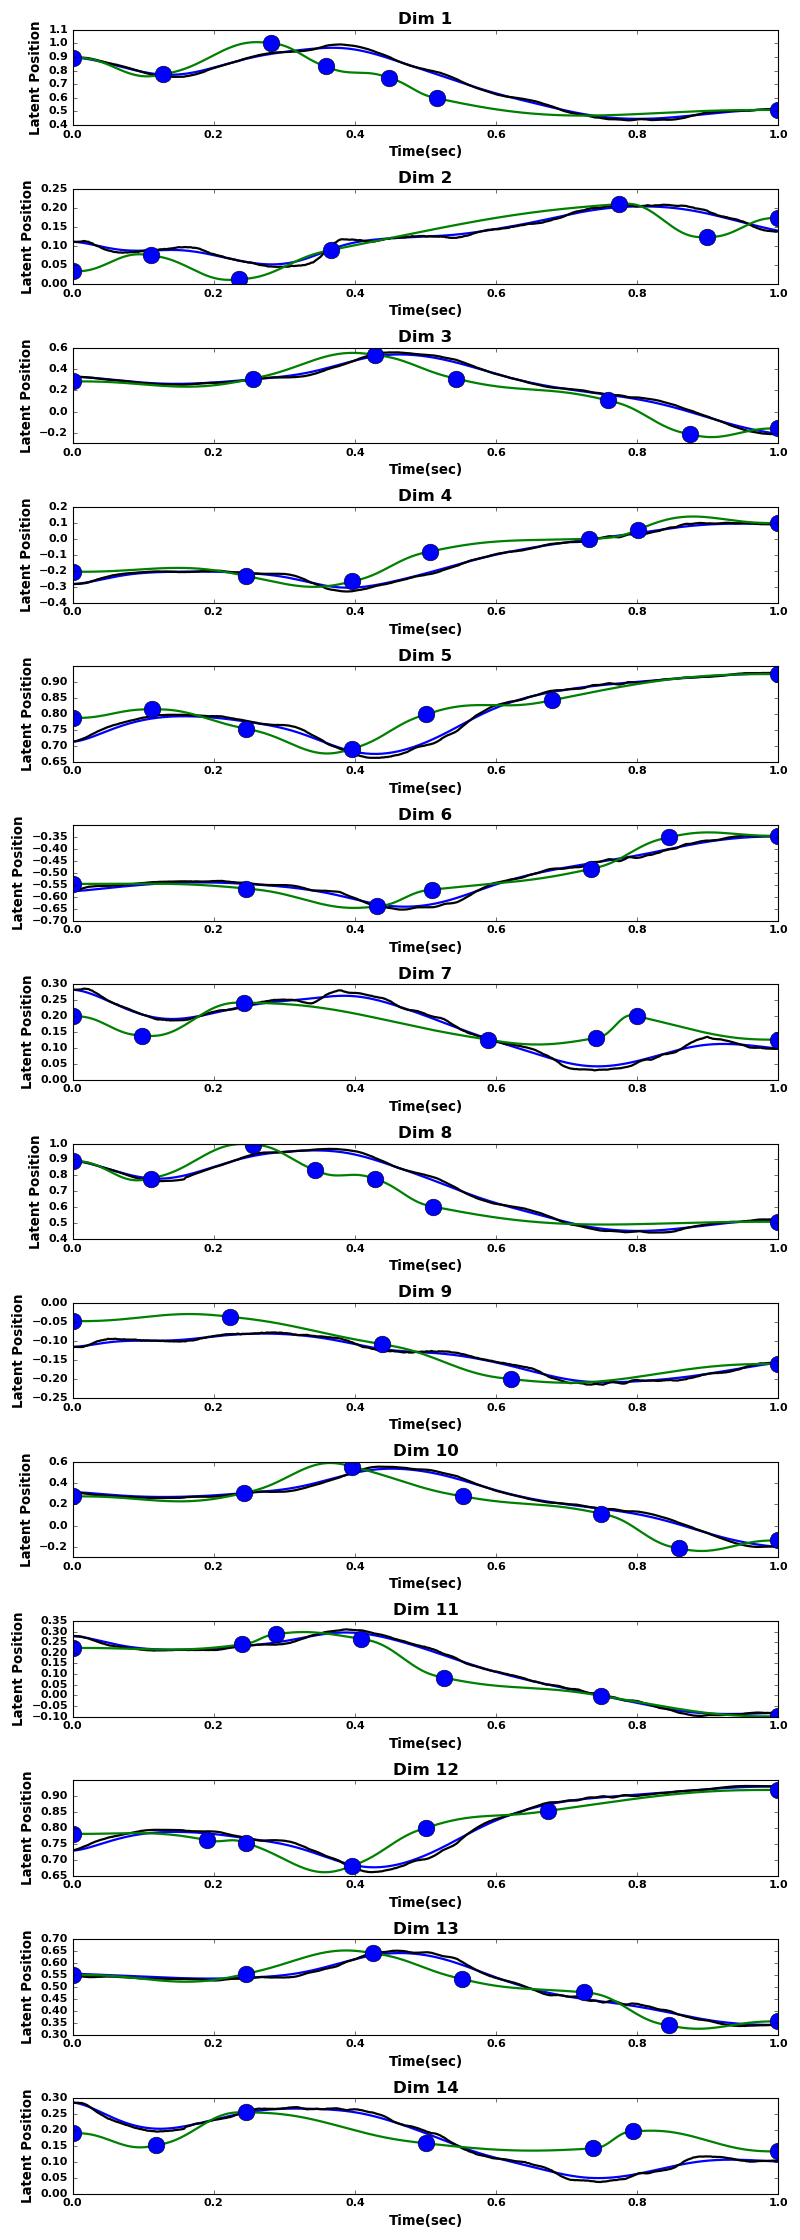

In [30]:
# initialize parameters for training DMPs
source = 'Train'
modality = 'input'
keys = ['JA', 'EE']
dims = {'JA':np.asarray(range(7)+range(8,14)), 'EE':np.arange(15)}

for key in keys:
    # get the relevant dimensions
    inputDim = dims[key]
    dmpTraj = dmpTrajs[modality][key]
    viapointTraj = viapointTrajs[key]
    viapointParam = viapointParams[key]
    data = Data[modality][key][source][:,inputDim]

    plotTraj2({'Raw':data,'DMP':dmpTraj,'VP':viapointTraj}, points=viapointParam, colors={'Raw':'k','DMP':'b','VP':'g'})

## Functions for RL
---

In [31]:
# implement reward function such that trajectory passes through desired via-points
def rewardFunc(trajectory, params):
    # parameter initialization
    reward = 0.0
    vpFactor = 1e2
    nDims = len(params.keys())
    
    # loop over the dimensions
    for nD in range(nDims):
        # get vps and trajectory
        vps = params[nD][:,:2]
        traj = trajectory[:,[0,nD+1]]
        
        # loop over the viapoints
        nVia = params[nD].shape[0]
        for nV in range(nVia):
            idx = (np.abs(traj[:,0]-vps[nV,0])).argmin()
            reward += vpFactor*((traj[idx,1]-vps[nV,1])**2)
    
    # return reward for complete trajectory
    return reward

In [32]:
def inferTraj(model,latTraj):
    # parameter initialization
    dim = model.Y.shape[1]
    lDim = latTraj.shape[1]-1
    nSamples = latTraj.shape[0]
    qDim = model.X.mean.shape[1]
    
    # initialize output trajectory
    outTraj = np.zeros((nSamples,dim+1))
    outTraj[:,0] = latTraj[:,0]
    
    # loop over the samples
    for n in range(nSamples):
        latData = np.zeros((1,qDim))
        latData[0,:lDim] = latTraj[n,1:]
        
        # return output data
        outData,_ = model.predict(latData)
        outTraj[n,1:] = outData
    
    # return the trajectory
    return outTraj

In [41]:
def gplvmTraj(model,latTraj):
    # parameter initialization
    dim = model.Y.shape[1]
    nSamples = latTraj.shape[0]
    qDim = model.X.shape[1]
    
    # initialize output trajectory
    outTraj = np.zeros((nSamples,dim+1))
    outTraj[:,0] = latTraj[:,0]
    
    # loop over the samples
    for n in range(nSamples):
        latData = np.zeros((1,qDim))
        latData[0,:] = latTraj[n,1:]
        
        # return output data
        outData,_ = model.predict(latData)
        outTraj[n,1:] = outData
    
    # return the trajectory
    return outTraj

In [42]:
def pcaTraj(model,latTraj):
    outTraj = model.inverse_transform(latTraj[:,1:])
    outTraj = np.concatenate((np.transpose(np.atleast_2d(latTraj[:,0])), outTraj), axis=1)
    
    # return the trajectory
    return outTraj

## Cross Entropy Method RL for Input JA Trajectory
---

In [33]:
# dictionary of final rewards for comparison
Rewards = {}

In [34]:
# obtain desired DMP
dmp = dmps['input']['JA']
dmpTraj = dmpTrajs['input']['JA']

# obtain desired via-points
vpParam = viapointParams['JA']

# obtain starting point and goal point for new trajectory
nDims = len(vpParam.keys())

# initialize policy parameters mean
policyMean = dmp.w

# initialize policy variance
policyVar = (policyMean)**2

# do monte-carlo rollouts and evaluate rewards
nKeep = 5
nRollouts = 50
nBFS = policyMean.shape[1]
nSamples = dmpTraj.shape[0]

# save the trajectories
colors = {}
epsRewards = {}
trajectories = {}

# number of iters to run loop
nIters = 50

0 561.12018618
1 494.215363567
2 453.439814828
3 418.208338714
4 396.60562272
5 370.601119364
6 346.272519254
7 332.999609769
8 318.374706128
9 306.526039553
10 297.075047633
11 289.626708398
12 283.454965842
13 277.944948601
14 274.326585469
15 270.912867923
16 267.3458627
17 265.094936253
18 262.705718983
19 261.103646768
20 259.255938381
21 257.919507841
22 257.039023749
23 256.015666433
24 255.30269625
25 254.72692658
26 254.286231622
27 253.981521428
28 253.632629628
29 253.228758016
30 253.018049381
31 252.736374054
32 252.569415981
33 252.386570149
34 252.261459713
35 252.155162659
36 252.074235938
37 252.000900379
38 251.929162118
39 251.863731854
40 251.829180135
41 251.801875257
42 251.777423882
43 251.756293752
44 251.743278592
45 251.726397871
46 251.711064452
47 251.696954222
48 251.685348622
49 251.677259717


<IPython.core.display.Javascript object>


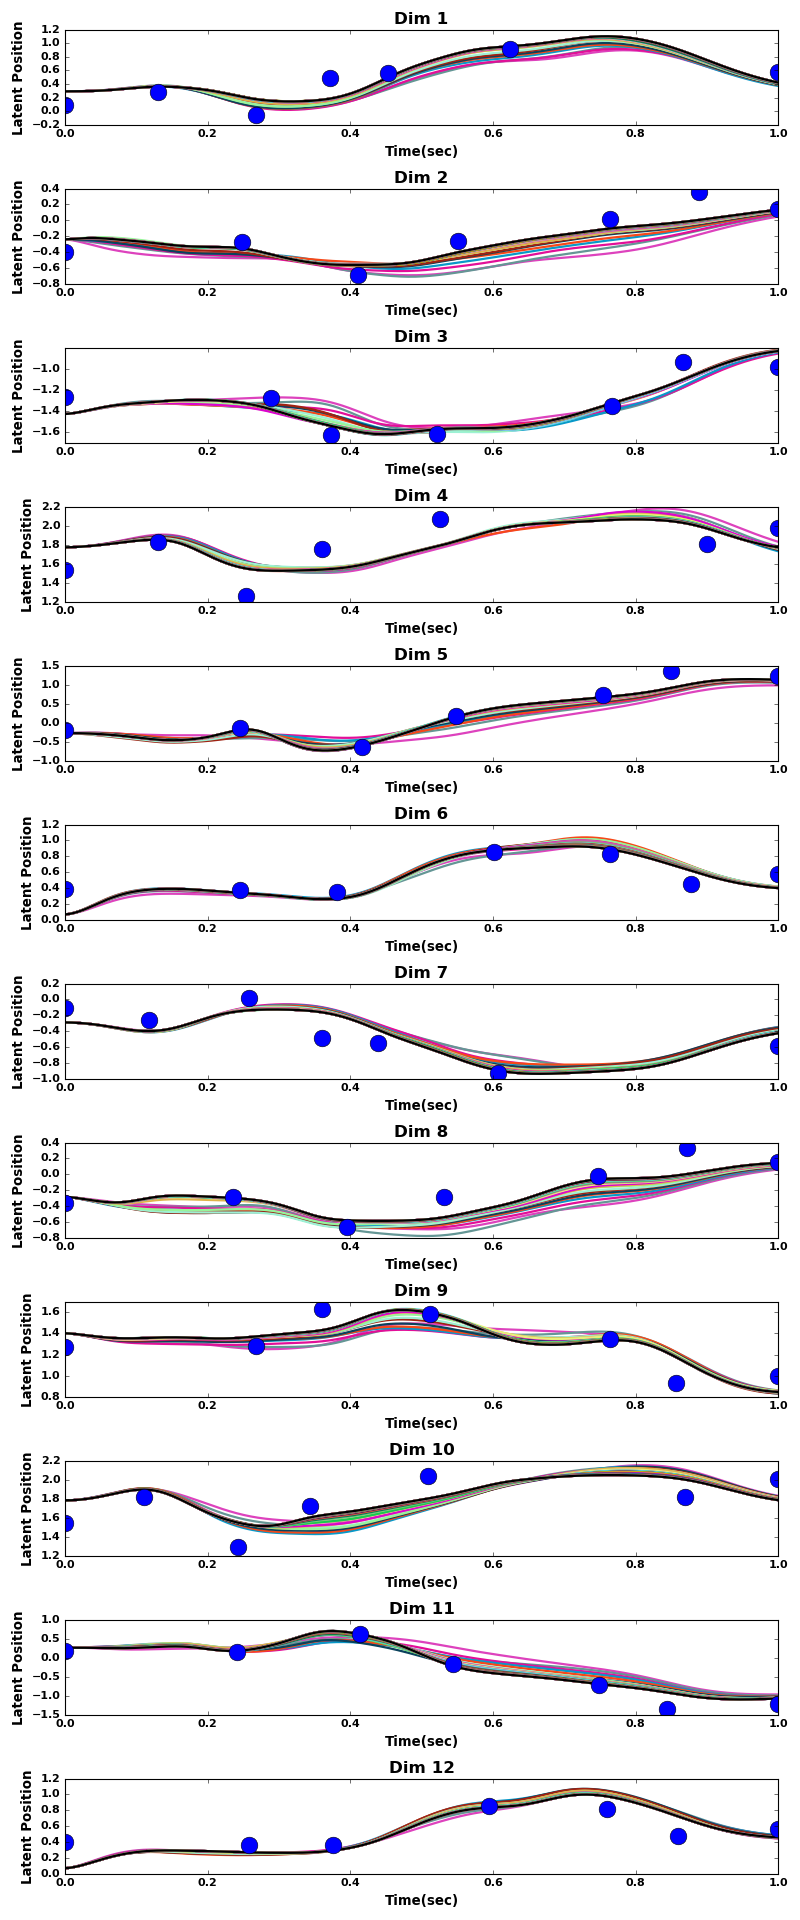

In [35]:
for it in range(nIters):
    trajs = {}
    rollouts = {}
    
    for nR in range(nRollouts):
        # parameter rollout
        rollout = policyMean.copy()
    
        # generate the rollout parameters 
        for d in range(nDims):
            mean = policyMean[d,:]
            cov = (policyVar[d,:])*np.eye(nBFS)
            rollout[d,:] = np.random.multivariate_normal(mean,cov)
        
        # generate trajectory from parameters
        rollouts[nR] = rollout
        dmp.w = rollouts[nR]
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['JA'][:,0])),dmpTraj),axis=1)
    
        trajs[nR] = dmpTraj

    # compute rewards for all the trajectories
    rewards = np.zeros(nRollouts)
    for key in trajs.keys():
        rewards[key] = rewardFunc(trajs[key],vpParam)
    
    # sort the rewards and keep the top few trials
    trajInds = rewards.argsort()[:nKeep]

    # obtain the best trajectories and policy parameters
    bestPolicies = np.zeros((nKeep,nDims,nBFS))
    for ind,trajInd in enumerate(trajInds):
        bestPolicies[ind,:,:] = rollouts[trajInd]

    # compute new means and variances for policy parameters
    policyMean = bestPolicies.mean(axis=0)
    policyVar = bestPolicies.var(axis=0)

    # generate trajectory from dmp
    dmp.w = policyMean
    dmpTraj,_,_ = dmp.rollout()
    dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['JA'][:,0])),dmpTraj),axis=1)
    
    trajectories[it] = dmpTraj
    colors[it] = np.random.rand(3,)
    epsRewards[it] = rewardFunc(trajectories[it],vpParam)
    
    print it, epsRewards[it]

Rewards['Org'] = epsRewards.copy()

colors['Org'] = 'k'
trajectories['Org'] = dmpTraj

plotTraj2(trajectories, points=vpParam, colors=colors)

## CEM RL for JA Latent Case
---

In [36]:
# obtain desired DMP
dmp = dmps['bgplvm']['JA']
model = models['JA']['BGPLVM']
dmpTraj = dmpTrajs['bgplvm']['JA']

# obtain desired via-points
vpParam = viapointParams['JA']

# number of dimensions in dmp
nDims = dmpTraj.shape[1]-1

# initialize policy parameters mean
policyMean = dmp.w

# initialize policy variance
policyVar = (policyMean)**2

# do monte-carlo rollouts and evaluate rewards
nKeep = 5
nRollouts = 50
nBFS = policyMean.shape[1]
nSamples = dmpTraj.shape[0]

# save the trajectories
colors = {}
epsRewards = {}
trajectories = {}

# number of iters to run loop
nIters = 50

0 401.650505939
1 337.950871988
2 272.400971021
3 241.906860729
4 223.49850671
5 208.057596299
6 203.773043774
7 192.501592459
8 187.566125292
9 181.686295198
10 178.655953259
11 174.538888815
12 171.848487045
13 169.524188826
14 168.248532846
15 166.913065284
16 165.381940271
17 164.240115772
18 163.700970273
19 163.430552558
20 163.133416786
21 162.659578561
22 162.242605139
23 162.02726313
24 161.719213621
25 161.470536795
26 161.245187301
27 161.109363765
28 161.011733398
29 160.931428075
30 160.851735001
31 160.796102733
32 160.756671468
33 160.717109295
34 160.672380588
35 160.649736017
36 160.618316958
37 160.598791833
38 160.583194977
39 160.572724572
40 160.564120212
41 160.558451781
42 160.554014572
43 160.548287048
44 160.54376997
45 160.538996399
46 160.534727284
47 160.531486887
48 160.52915466
49 160.527291806


<IPython.core.display.Javascript object>


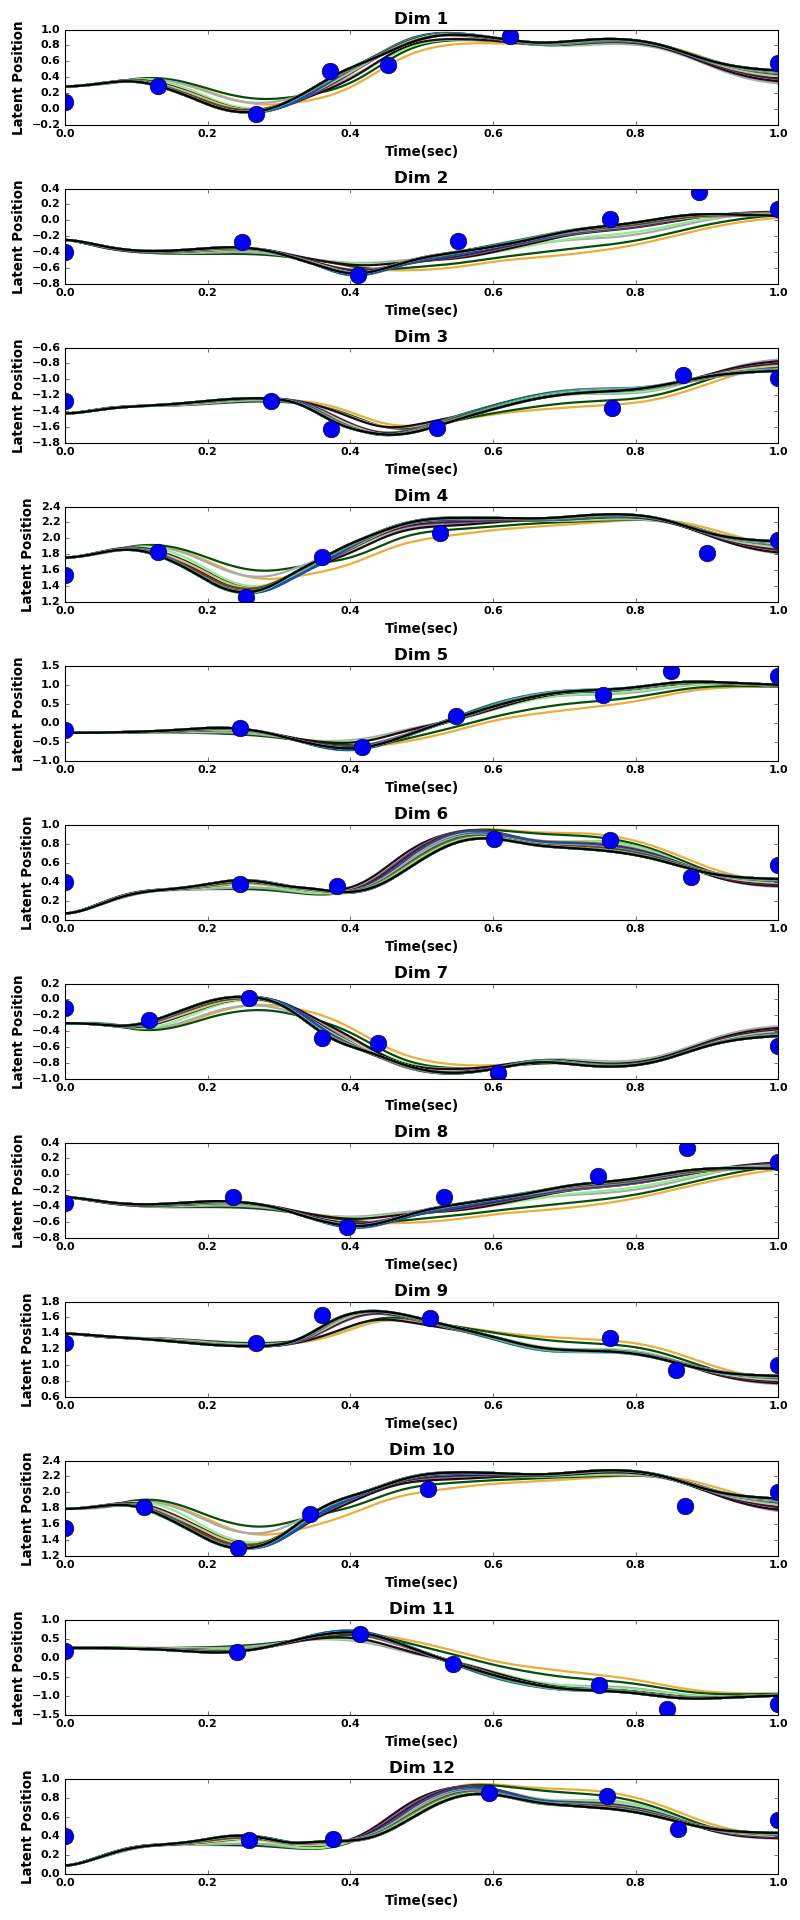

In [37]:
for it in range(nIters):
    trajs = {}
    rollouts = {}
    
    for nR in range(nRollouts):
        # parameter rollout
        rollout = policyMean.copy()
    
        # generate the rollout parameters 
        for d in range(nDims):
            mean = policyMean[d,:]
            cov = (policyVar[d,:])*np.eye(nBFS)
            rollout[d,:] = np.random.multivariate_normal(mean,cov)
        
        # generate trajectory from parameters
        rollouts[nR] = rollout
        dmp.w = rollouts[nR]
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['JA'][:,0])),dmpTraj),axis=1)

        outputTraj = inferTraj(model,dmpTraj)
        outputTraj = outputTraj[:,dims['JA']]
        trajs[nR] = outputTraj

    # compute rewards for all the trajectories
    rewards = np.zeros(nRollouts)
    for key in trajs.keys():
        rewards[key] = rewardFunc(trajs[key],vpParam)
    
    # sort the rewards and keep the top few trials
    trajInds = rewards.argsort()[:nKeep]

    # obtain the best trajectories and policy parameters
    bestPolicies = np.zeros((nKeep,nDims,nBFS))
    for ind,trajInd in enumerate(trajInds):
        bestPolicies[ind,:,:] = rollouts[trajInd]

    # compute new means and variances for policy parameters
    policyMean = bestPolicies.mean(axis=0)
    policyVar = bestPolicies.var(axis=0)

    # generate trajectory from dmp
    dmp.w = policyMean
    dmpTraj,_,_ = dmp.rollout()
    dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['bgplvm']['JA'][:,0])),dmpTraj),axis=1)
    
    # generate output trajectory
    outputTraj = inferTraj(model,dmpTraj)
    outputTraj = outputTraj[:,dims['JA']]    
    
    # save results
    trajectories[it] = outputTraj
    colors[it] = np.random.rand(3,)
    epsRewards[it] = rewardFunc(trajectories[it],vpParam)
    
    print it, epsRewards[it]

Rewards['BGPLVM'] = epsRewards.copy()
    
colors['Org'] = 'k'
trajectories['Org'] = outputTraj

plotTraj2(trajectories, points=vpParam, colors=colors)

In [38]:
# obtain desired DMP
dmp = dmps['gplvm']['JA']
model = models['JA']['GPLVM']
dmpTraj = dmpTrajs['gplvm']['JA']

# obtain desired via-points
vpParam = viapointParams['JA']

# number of dimensions in dmp
nDims = dmpTraj.shape[1]-1

# initialize policy parameters mean
policyMean = dmp.w

# initialize policy variance
policyVar = (policyMean)**2

# do monte-carlo rollouts and evaluate rewards
nKeep = 5
nRollouts = 50
nBFS = policyMean.shape[1]
nSamples = dmpTraj.shape[0]

# save the trajectories
colors = {}
epsRewards = {}
trajectories = {}

# number of iters to run loop
nIters = 50

0 487.505965888
1 365.341703172
2 299.352300239
3 267.371820727
4 261.837326526
5 240.715913403
6 230.388544757
7 225.682528189
8 222.534282531
9 212.705300241
10 205.258691078
11 200.282107953
12 196.911362126
13 193.811328594
14 192.121444615
15 190.18395536
16 188.17499548
17 186.81375507
18 185.655365316
19 184.605169217
20 183.858308952
21 183.268442505
22 182.708638541
23 182.40093477
24 181.967592375
25 181.600031246
26 181.245876826
27 180.935412928
28 180.720733237
29 180.601160457
30 180.496382817
31 180.400900412
32 180.34436547
33 180.283274326
34 180.231342884
35 180.186447285
36 180.166543204
37 180.145336476
38 180.124880343
39 180.10361356
40 180.089696613
41 180.079857549
42 180.066899308
43 180.059751534
44 180.051697321
45 180.046252659
46 180.039419115
47 180.03257879
48 180.029072554
49 180.026339489


<IPython.core.display.Javascript object>


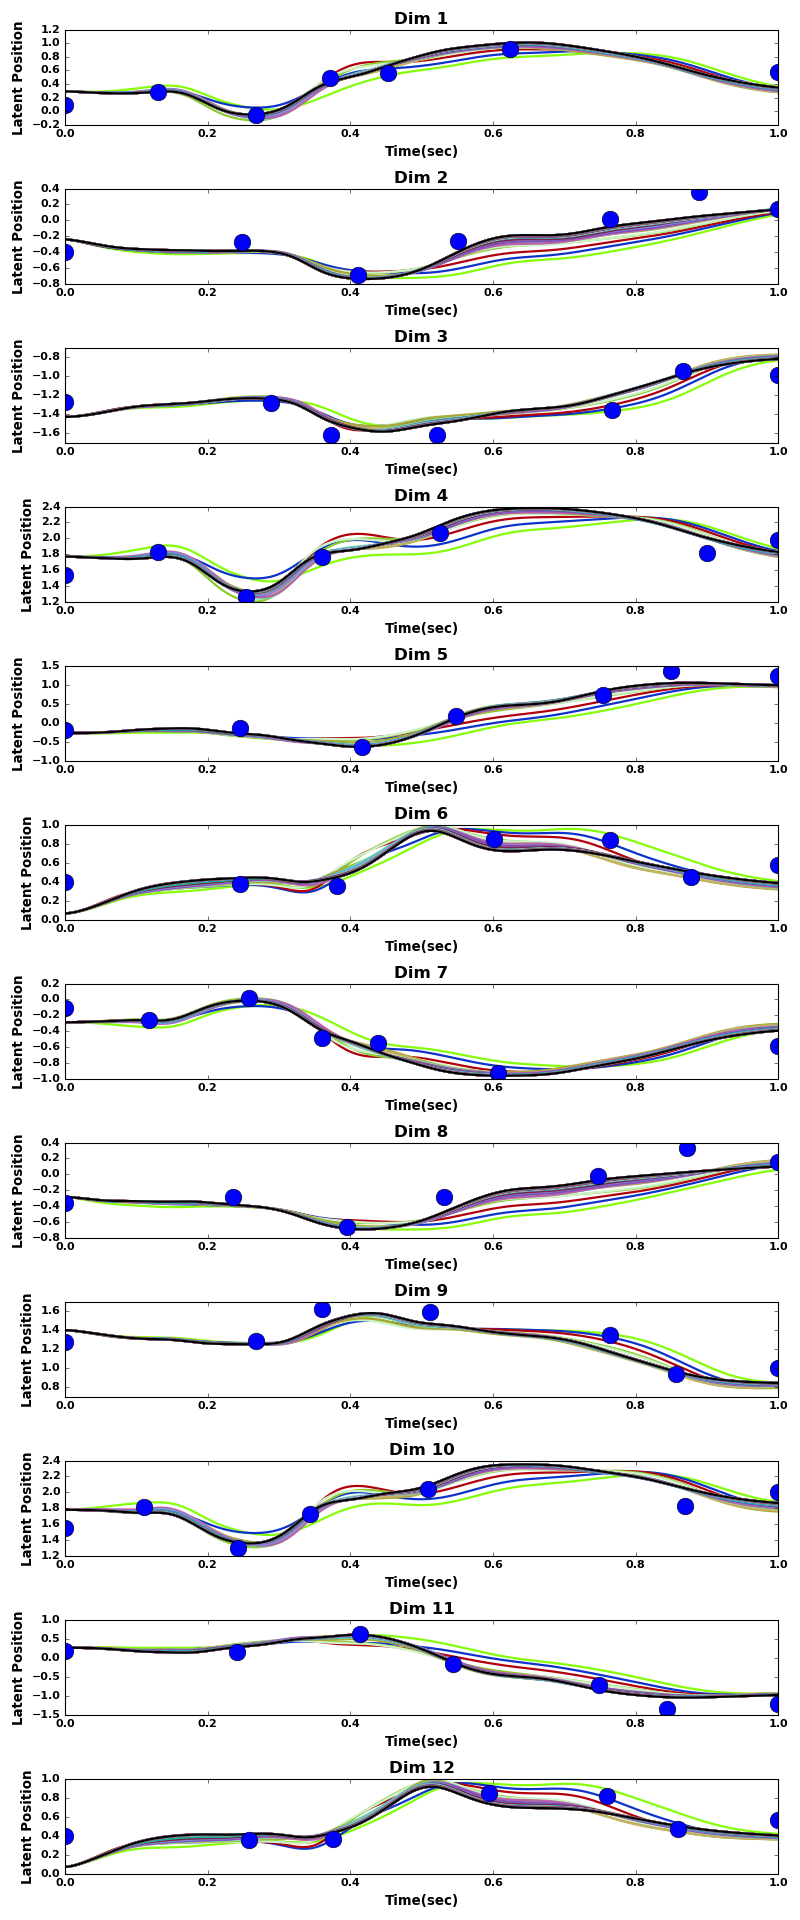

In [43]:
for it in range(nIters):
    trajs = {}
    rollouts = {}
    
    for nR in range(nRollouts):
        # parameter rollout
        rollout = policyMean.copy()
    
        # generate the rollout parameters 
        for d in range(nDims):
            mean = policyMean[d,:]
            cov = (policyVar[d,:])*np.eye(nBFS)
            rollout[d,:] = np.random.multivariate_normal(mean,cov)
        
        # generate trajectory from parameters
        rollouts[nR] = rollout
        dmp.w = rollouts[nR]
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['JA'][:,0])),dmpTraj),axis=1)

        outputTraj = gplvmTraj(model,dmpTraj)
        outputTraj = outputTraj[:,dims['JA']]
        trajs[nR] = outputTraj

    # compute rewards for all the trajectories
    rewards = np.zeros(nRollouts)
    for key in trajs.keys():
        rewards[key] = rewardFunc(trajs[key],vpParam)
    
    # sort the rewards and keep the top few trials
    trajInds = rewards.argsort()[:nKeep]

    # obtain the best trajectories and policy parameters
    bestPolicies = np.zeros((nKeep,nDims,nBFS))
    for ind,trajInd in enumerate(trajInds):
        bestPolicies[ind,:,:] = rollouts[trajInd]

    # compute new means and variances for policy parameters
    policyMean = bestPolicies.mean(axis=0)
    policyVar = bestPolicies.var(axis=0)

    # generate trajectory from dmp
    dmp.w = policyMean
    dmpTraj,_,_ = dmp.rollout()
    dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['gplvm']['JA'][:,0])),dmpTraj),axis=1)
    
    # generate output trajectory
    outputTraj = gplvmTraj(model,dmpTraj)
    outputTraj = outputTraj[:,dims['JA']]    
    
    # save results
    trajectories[it] = outputTraj
    colors[it] = np.random.rand(3,)
    epsRewards[it] = rewardFunc(trajectories[it],vpParam)
    
    print it, epsRewards[it]

Rewards['GPLVM'] = epsRewards.copy()
    
colors['Org'] = 'k'
trajectories['Org'] = outputTraj

plotTraj2(trajectories, points=vpParam, colors=colors)

In [46]:
# obtain desired DMP
dmp = dmps['pca']['JA']
model = models['JA']['PCA']['model']
dmpTraj = dmpTrajs['pca']['JA']

# obtain desired via-points
vpParam = viapointParams['JA']

# number of dimensions in dmp
nDims = dmpTraj.shape[1]-1

# initialize policy parameters mean
policyMean = dmp.w

# initialize policy variance
policyVar = (policyMean)**2

# do monte-carlo rollouts and evaluate rewards
nKeep = 5
nRollouts = 50
nBFS = policyMean.shape[1]
nSamples = dmpTraj.shape[0]

# save the trajectories
colors = {}
epsRewards = {}
trajectories = {}

# number of iters to run loop
nIters = 50

0 378.523522891
1 313.068348676
2 275.704561578
3 255.180643831
4 242.232604497
5 225.571674959
6 216.89818023
7 207.278998983
8 202.603795087
9 197.677386513
10 193.790223317
11 190.066659705
12 186.868073668
13 184.908373078
14 183.069176495
15 181.859154779
16 180.847095907
17 180.113965211
18 179.492090309
19 178.802002889
20 178.499552392
21 178.1150651
22 177.738789727
23 177.451472997
24 177.237812503
25 177.076933144
26 176.942281693
27 176.829932495
28 176.755969603
29 176.685389255
30 176.623482664
31 176.584501405
32 176.55086679
33 176.515506249
34 176.487381898
35 176.461030546
36 176.440185595
37 176.415708902
38 176.39863461
39 176.386001746
40 176.375675302
41 176.363957299
42 176.354170444
43 176.345812415
44 176.338582474
45 176.332384506
46 176.327462778
47 176.324088224
48 176.322330789
49 176.32100418


<IPython.core.display.Javascript object>


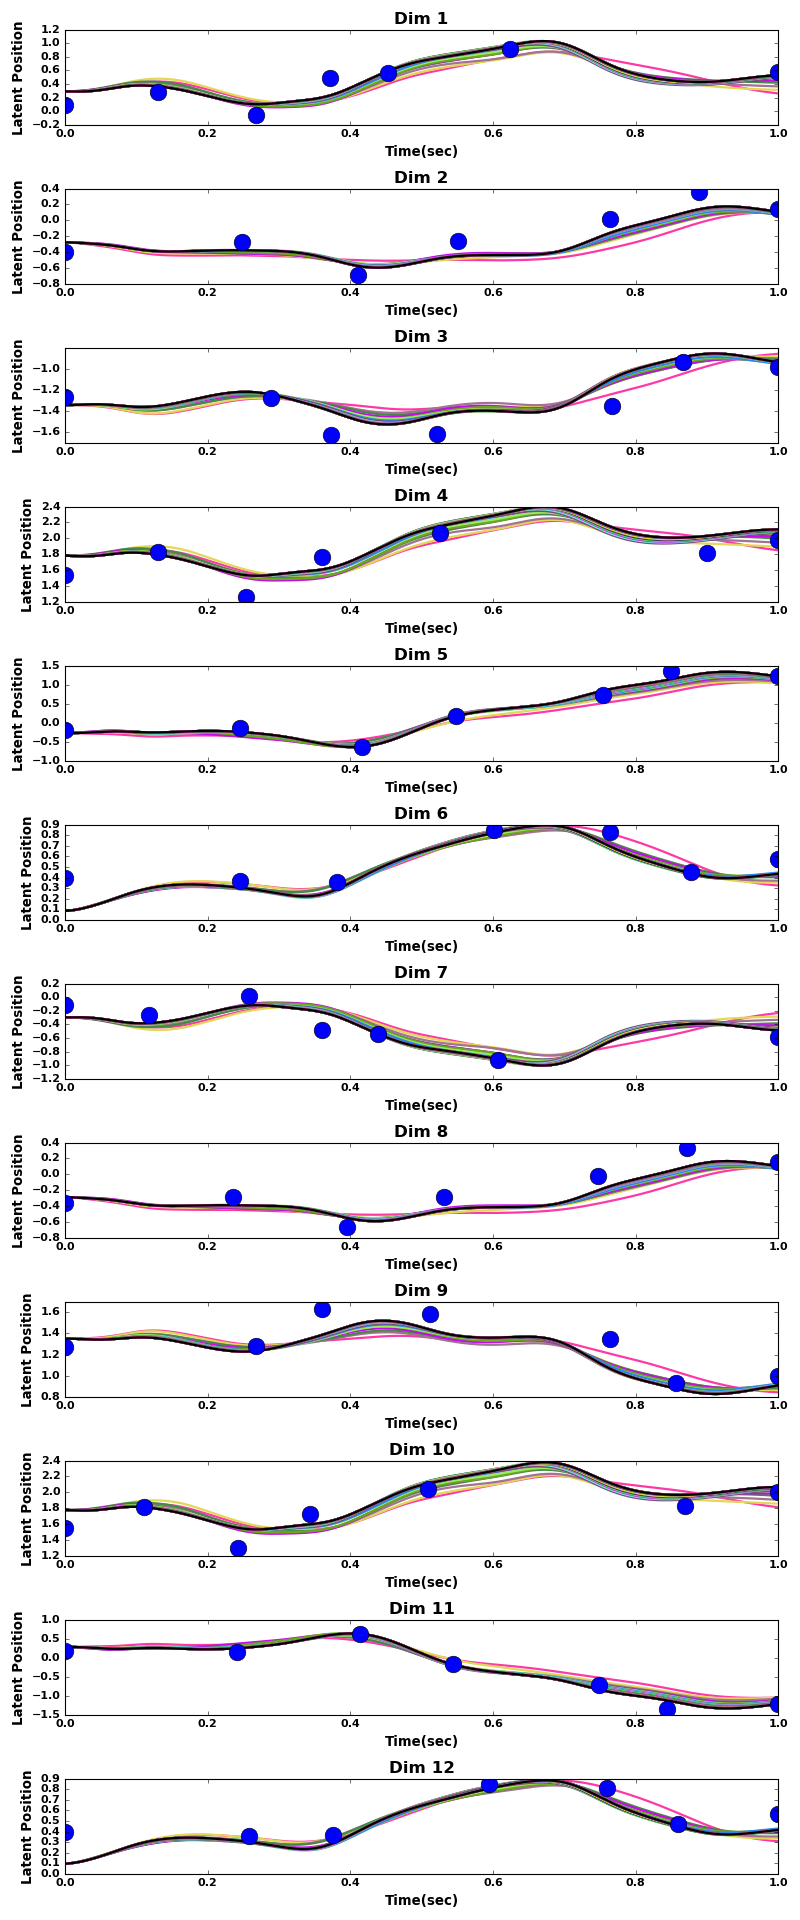

In [48]:
for it in range(nIters):
    trajs = {}
    rollouts = {}
    
    for nR in range(nRollouts):
        # parameter rollout
        rollout = policyMean.copy()
    
        # generate the rollout parameters 
        for d in range(nDims):
            mean = policyMean[d,:]
            cov = (policyVar[d,:])*np.eye(nBFS)
            rollout[d,:] = np.random.multivariate_normal(mean,cov)
        
        # generate trajectory from parameters
        rollouts[nR] = rollout
        dmp.w = rollouts[nR]
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['JA'][:,0])),dmpTraj),axis=1)

        outputTraj = pcaTraj(model,dmpTraj)
        outputTraj = outputTraj[:,dims['JA']]
        trajs[nR] = outputTraj

    # compute rewards for all the trajectories
    rewards = np.zeros(nRollouts)
    for key in trajs.keys():
        rewards[key] = rewardFunc(trajs[key],vpParam)
    
    # sort the rewards and keep the top few trials
    trajInds = rewards.argsort()[:nKeep]

    # obtain the best trajectories and policy parameters
    bestPolicies = np.zeros((nKeep,nDims,nBFS))
    for ind,trajInd in enumerate(trajInds):
        bestPolicies[ind,:,:] = rollouts[trajInd]

    # compute new means and variances for policy parameters
    policyMean = bestPolicies.mean(axis=0)
    policyVar = bestPolicies.var(axis=0)

    # generate trajectory from dmp
    dmp.w = policyMean
    dmpTraj,_,_ = dmp.rollout()
    dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['pca']['JA'][:,0])),dmpTraj),axis=1)
    
    # generate output trajectory
    outputTraj = pcaTraj(model,dmpTraj)
    outputTraj = outputTraj[:,dims['JA']]    
    
    # save results
    trajectories[it] = outputTraj
    colors[it] = np.random.rand(3,)
    epsRewards[it] = rewardFunc(trajectories[it],vpParam)
    
    print it, epsRewards[it]

Rewards['PCA'] = epsRewards.copy()
    
colors['Org'] = 'k'
trajectories['Org'] = outputTraj

plotTraj2(trajectories, points=vpParam, colors=colors)

## Model Comparison
---

In [1]:
fig = plt.figure()
xDat = 50*np.arange(1,51)
plt.plot(xDat, Rewards['Org'].values(), label='Joint Angle', color='k', linewidth=2)
plt.plot(xDat, Rewards['PCA'].values(), label='PCA Space', color='r', linewidth=2)
plt.plot(xDat, Rewards['GPLVM'].values(), label='GPLVM Space', color='g', linewidth=2)
plt.plot(xDat, Rewards['BGPLVM'].values(), label='BGPLVM Space', color='b', linewidth=2)

plt.xlabel('# Episodes', fontsize=20, fontweight='bold')
plt.ylabel('Reward', fontsize=20, fontweight='bold')
#plt.title('Comparison', fontsize=20, fontweight='bold')

plt.legend()
plt.show()

NameError: name 'plt' is not defined

## Cross Entropy Method RL for Input EE Trajectory
---

In [ ]:
Rewards = {}

In [ ]:
# obtain desired DMP
dmp = dmps['input']['EE']
dmpTraj = dmpTrajs['input']['EE']

# obtain desired via-points
vpParam = viapointParams['EE']

# obtain starting point and goal point for new trajectory
nDims = len(vpParam.keys())

# initialize policy parameters mean
policyMean = dmp.w

# initialize policy variance
policyVar = (policyMean)**2

# do monte-carlo rollouts and evaluate rewards
nKeep = 5
nRollouts = 50
nBFS = policyMean.shape[1]
nSamples = dmpTraj.shape[0]

# save the trajectories
colors = {}
epsRewards = {}
trajectories = {}

# number of iters to run loop
nIters = 50

In [ ]:
for it in range(nIters):
    trajs = {}
    rollouts = {}
    
    for nR in range(nRollouts):
        # parameter rollout
        rollout = policyMean.copy()
    
        # generate the rollout parameters 
        for d in range(nDims):
            mean = policyMean[d,:]
            cov = (policyVar[d,:])*np.eye(nBFS)
            rollout[d,:] = np.random.multivariate_normal(mean,cov)
        
        # generate trajectory from parameters
        rollouts[nR] = rollout
        dmp.w = rollouts[nR]
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['EE'][:,0])),dmpTraj),axis=1)
    
        trajs[nR] = dmpTraj

    # compute rewards for all the trajectories
    rewards = np.zeros(nRollouts)
    for key in trajs.keys():
        rewards[key] = rewardFunc(trajs[key],vpParam)
    
    # sort the rewards and keep the top few trials
    trajInds = rewards.argsort()[:nKeep]

    # obtain the best trajectories and policy parameters
    bestPolicies = np.zeros((nKeep,nDims,nBFS))
    for ind,trajInd in enumerate(trajInds):
        bestPolicies[ind,:,:] = rollouts[trajInd]

    # compute new means and variances for policy parameters
    policyMean = bestPolicies.mean(axis=0)
    policyVar = bestPolicies.var(axis=0)

    # generate trajectory from dmp
    dmp.w = policyMean
    dmpTraj,_,_ = dmp.rollout()
    dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['EE'][:,0])),dmpTraj),axis=1)
    
    trajectories[it] = dmpTraj
    colors[it] = np.random.rand(3,)
    epsRewards[it] = rewardFunc(trajectories[it],vpParam)
    
    print it, epsRewards[it]

Rewards['Org'] = epsRewards.copy()

colors['Org'] = 'k'
trajectories['Org'] = dmpTraj

plotTraj2(trajectories, points=vpParam, colors=colors)

In [ ]:
# obtain desired DMP
model = models['EE']['BGPLVM']
dmp = dmps['latent']['EE']
dmpTraj = dmpTrajs['latent']['EE']

# obtain desired via-points
vpParam = viapointParams['EE']

# number of dimensions in dmp
nDims = dmpTraj.shape[1]-1

# initialize policy parameters mean
policyMean = dmp.w

# initialize policy variance
policyVar = (policyMean)**2

# do monte-carlo rollouts and evaluate rewards
nKeep = 5
nRollouts = 50
nBFS = policyMean.shape[1]
nSamples = dmpTraj.shape[0]

# save the trajectories
colors = {}
epsRewards = {}
trajectories = {}

# number of iters to run loop
nIters = 50

In [ ]:
for it in range(nIters):
    trajs = {}
    rollouts = {}
    
    for nR in range(nRollouts):
        # parameter rollout
        rollout = policyMean.copy()
    
        # generate the rollout parameters 
        for d in range(nDims):
            mean = policyMean[d,:]
            cov = (policyVar[d,:])*np.eye(nBFS)
            rollout[d,:] = np.random.multivariate_normal(mean,cov)
        
        # generate trajectory from parameters
        rollouts[nR] = rollout
        dmp.w = rollouts[nR]
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['EE'][:,0])),dmpTraj),axis=1)

        outputTraj = inferTraj(model,dmpTraj)
        outputTraj = outputTraj[:,dims['input']['EE']]
        trajs[nR] = outputTraj

    # compute rewards for all the trajectories
    rewards = np.zeros(nRollouts)
    for key in trajs.keys():
        rewards[key] = rewardFunc(trajs[key],vpParam)
    
    # sort the rewards and keep the top few trials
    trajInds = rewards.argsort()[:nKeep]

    # obtain the best trajectories and policy parameters
    bestPolicies = np.zeros((nKeep,nDims,nBFS))
    for ind,trajInd in enumerate(trajInds):
        bestPolicies[ind,:,:] = rollouts[trajInd]

    # compute new means and variances for policy parameters
    policyMean = bestPolicies.mean(axis=0)
    policyVar = bestPolicies.var(axis=0)

    # generate trajectory from dmp
    dmp.w = policyMean
    dmpTraj,_,_ = dmp.rollout()
    dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['latent']['EE'][:,0])),dmpTraj),axis=1)
    
    # generate output trajectory
    outputTraj = inferTraj(model,dmpTraj)
    outputTraj = outputTraj[:,dims['input']['EE']]    
    
    # save results
    trajectories[it] = outputTraj
    colors[it] = np.random.rand(3,)
    epsRewards[it] = rewardFunc(trajectories[it],vpParam)
    
    print it, epsRewards[it]

Rewards['Lat'] = epsRewards.copy()
    
colors['Org'] = 'k'
trajectories['Org'] = outputTraj

plotTraj2(trajectories, points=vpParam, colors=colors)

In [ ]:
fig = plt.figure()
xDat = 50*np.arange(1,51)
plt.plot(xDat, Rewards['Org'].values(), label='EE', color='r', linewidth=2)
plt.plot(xDat, Rewards['Lat'].values(), label='Lat', color='b', linewidth=2)

plt.xlabel('# Episodes', fontsize=15, fontweight='bold')
plt.ylabel('Reward', fontsize=15, fontweight='bold')
plt.title('Comparison', fontsize=20, fontweight='bold')

plt.legend()
plt.show()